_Version log: Finding the best samples though brute force and manual tweaking_

In [12]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [13]:
file_name = "1dmockanderrors12"
file_type = ".csv"
reduced_points = 8

target, uncertainties = cs.open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [14]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [15]:
#test = [11,15,24,27,44,66,85,126] #PCA
#test = [72,76,79,89,96,100,107,117] #RPCA
#test = [0,88,94,100,104,124,165,190] #[31,55,62,70,79,83,93,100,104,111,125,132,139,149,159,197] # Manual
#test = [10,45,57,95,98,144,168,195] # SA
#test = [18,58,75,88,95,97,139,181] #MCMC
#test = [1,89,90,95,95,96,97,98,100,102,105,111,119,123,134,179] #Brute force
test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular")

test = np.array(test)

len(test)

8

In [16]:
np.diff(test)

array([28, 29, 28, 29, 28, 29, 28])

In [17]:
full_data = np.vstack([full_data, test])
full_data.shape

(102, 8)

In [18]:
regularization_coeffient = 1e-4

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    result = cs.compressed_sensing(target[locations], locations, total_points, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


  5%|▍         | 5/102 [00:00<00:02, 44.79it/s]

100%|██████████| 102/102 [00:01<00:00, 73.02it/s]


In [19]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

5.448862853622519


In [20]:
print(*zip(errors, full_data), sep= "\n")

(1.258211409411606, array([ 10,  45,  57,  95,  98, 144, 168, 195]))
(2.291283095514126, array([  2,  10,  81,  85,  90, 148, 165, 189]))
(3.151048302199871, array([  2,  25,  52,  83, 123, 127, 160, 188]))
(3.2036845661890028, array([  9,  33,  70,  91, 123, 126, 167, 196]))
(3.2440596960925716, array([  5,  24,  74,  78, 118, 145, 157, 189]))
(3.278806591680679, array([  1,  33,  65,  84, 124, 127, 181, 197]))
(3.3085913903764403, array([  2,  18,  64,  83, 128, 134, 167, 198]))
(3.31198505542589, array([  5,  31,  61,  83, 129, 134, 166, 194]))
(3.312843136196724, array([ 11,  46,  63,  83, 128, 134, 166, 197]))
(3.3893003135099518, array([  4,  32,  63,  75, 129, 134, 166, 192]))
(3.40636243749572, array([  2,  24,  56,  77, 118, 130, 174, 196]))
(3.4124798832957572, array([  9,  18,  51,  72, 118, 137, 180, 191]))
(3.415524771967958, array([  9,  21,  55,  90, 118, 131, 178, 194]))
(3.418514149044314, array([  1,  26,  58,  77, 125, 140, 169, 198]))
(3.4410558370709103, array([  9

In [21]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

-2.11998294930133


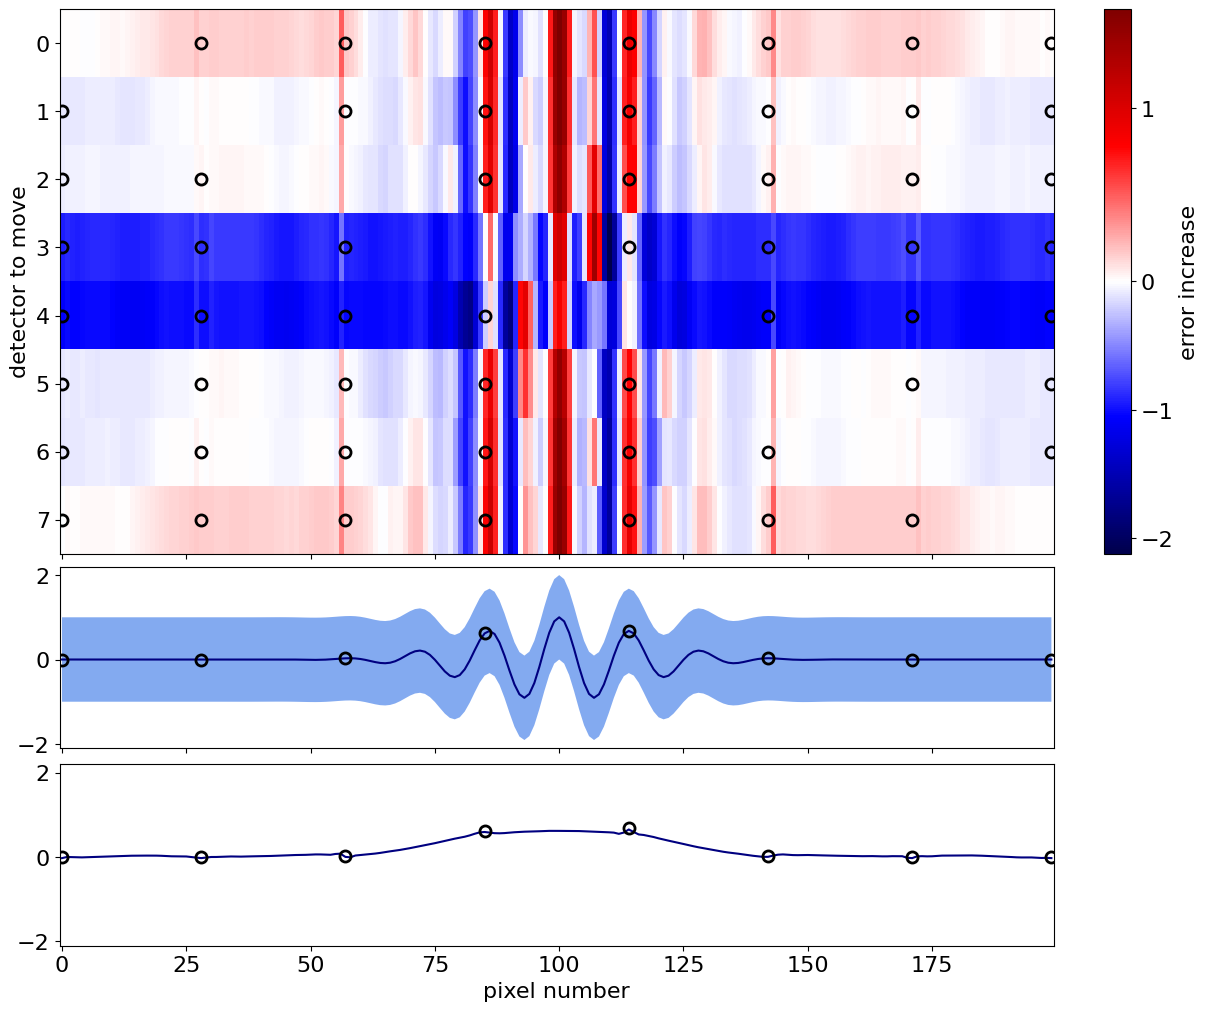

In [22]:
difference = brute_errors -sa_error

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

fig, axs = plt.subplots(3, 1, figsize= (12, 10), sharex= True, height_ratios= (3, 1, 1), layout= "constrained")

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements
im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= "seismic", norm= norm)
plt.colorbar(im, ticks= zticks, label= "error increase")

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move")

axs[1].plot(target, color= "navy", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "cornflowerblue", alpha= 0.8, label= "± std uncertrainty")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)

axs[2].plot(cs.compressed_sensing(target[test], test, total_points, regularization_coeffient), color= "navy")
axs[2].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)
axs[2].set(xlabel= "pixel number", ylim= axs[1].get_ylim())

plt.show()